In [481]:
import numpy as np 
import igraph as ig
import leidenalg as la
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import normalized_mutual_info_score

iter = 2
data_number = 2

data_path = f'dataset/TC1-{data_number}/1-{data_number}.dat'
label_path = f'dataset/TC1-{data_number}/1-{data_number}-c.dat'

data = np.loadtxt(data_path).astype(int)
graph = ig.Graph(data, directed=False)
partition = la.find_partition(graph, la.ModularityVertexPartition, n_iterations=iter, seed=7777,)
vertices = graph.vcount()

answer = pd.read_csv(label_path, sep='\t', header=None)
labels = answer[1].values

print(f"{len(partition)} clusters found")
print(f"Number of vertexes: {vertices}")

6 clusters found
Number of vertexes: 63


In [482]:
pred_labels = [0] * (vertices - 1)
for id, nodes in enumerate(partition):
    for node in nodes:
        pred_labels[node - 1] = id

pred_labels = np.array(pred_labels)
original_nmi = normalized_mutual_info_score(answer[1], pred_labels)

original_modularity = partition.modularity
print(f"Original NMI: {original_nmi}")
print(f"Original modularity: {original_modularity}")

Original NMI: 0.49835093340105224
Original modularity: 0.5241090146750523


In [483]:
cluster_set = []

n_of_valid_vertices = 0
for cluster_index, cluster_vertices in tqdm(enumerate(partition), total=len(partition)):
    new_graph = []
    for index in range(len(data)):
        node1, node2 = data[index]
        # assert node1 != node2
        if node1 in cluster_vertices and node2 in cluster_vertices:
            new_graph.append([node1, node2])

    new_graph = np.array(new_graph)
    unique_nodes, count = np.unique(new_graph, return_counts=True)
    
    # Mapping
    old2new = {}
    new2old = {}
    for i, node in enumerate(unique_nodes):
        old2new[node] = i
        new2old[i] = node
        
    new_vertices = np.array([[old2new[node1], old2new[node2]] for node1, node2 in new_graph])
    if len(new_vertices) == 0:
        print(f'{cluster_index} is empty')
        continue
    
    if np.random.rand() >= 0.5:
        cluster_set.append(list(cluster_vertices))
        continue
    
    # Generate sub-graphs
    new_graph = ig.Graph(new_vertices, directed=False)
    sub_partition = la.find_partition(new_graph, la.ModularityVertexPartition, n_iterations=iter, seed=7777)
    n_of_valid_vertices += len(cluster_vertices)

    # if len(unique_nodes) != len(cluster_vertices):
    #     print(list(unique_nodes))
    #     print(cluster_vertices)

    check_assert_list = []
    for index, sub_vertices in enumerate(sub_partition):
        old_sub_vertices = []
        for new_vertex in sub_vertices:
            old_sub_vertices.append(new2old[new_vertex])
        check_assert_list.extend(old_sub_vertices)
        if len(old_sub_vertices) != 0:
            cluster_set.append(old_sub_vertices)

    #     assert len(old_sub_vertices) != 0
    
    # check_assert = False
    # assert len(check_assert_list) == len(list(old2new.keys()))
    # for node1, node2 in zip(sorted(check_assert_list), sorted(list(old2new.keys()))):
    #     assert node1 == node2
        

100%|██████████| 6/6 [00:00<00:00, 2345.15it/s]

5 is empty


In [484]:
print(f"Found clusters: {len(cluster_set)}")
total_nodes = 0
for index, cluster in enumerate(cluster_set):
    total_nodes += len(cluster)
print(f"Total nodes: {total_nodes}")

Found clusters: 11
Total nodes: 62


<BarContainer object of 2 artists>

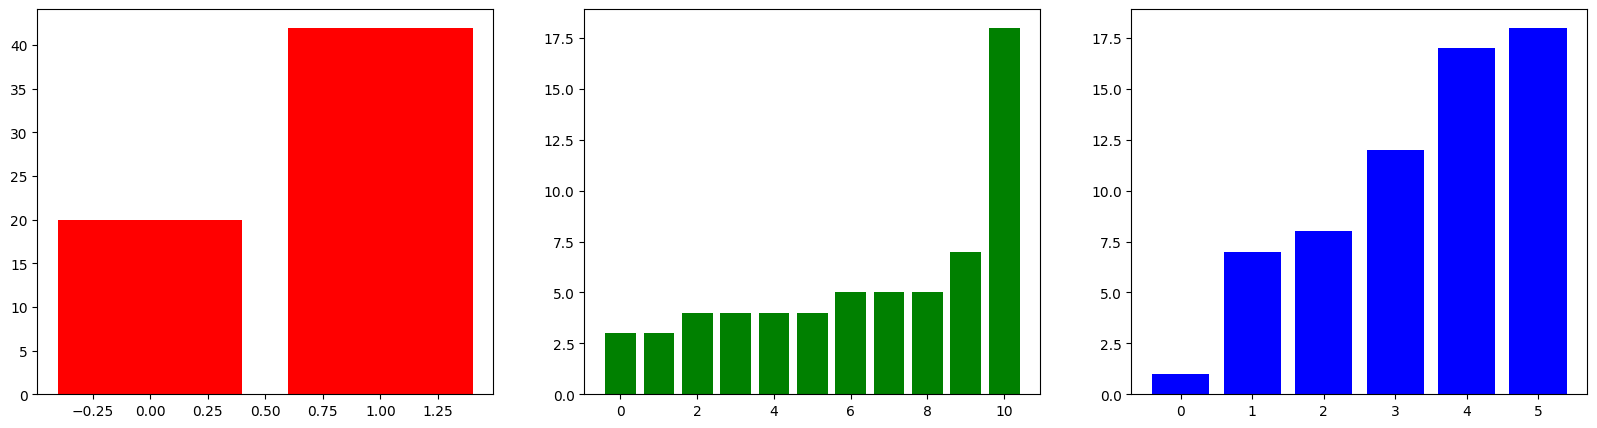

In [485]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
counts = sorted([len(cluster) for cluster in partition])
axes[2].bar(range(len(counts)), counts, color='b')

counts = sorted([len(cluster) for cluster in cluster_set])
axes[1].bar(range(len(counts)), counts, color='g')

unique, counts = np.unique(labels, return_counts=True)
counts = sorted(counts)
axes[0].bar(range(len(counts)), counts, color='r')



In [486]:
pred_labels = [0] * total_nodes
for id, nodes in enumerate(cluster_set):
    for node in nodes:
        pred_labels[node - 1] = id

pred_labels = np.array(pred_labels)
sub_nmi = normalized_mutual_info_score(answer[1], pred_labels)
print(f"Ori NMI: {original_nmi}")
print(f"Sub NMI: {sub_nmi}")

print("Improvement: ", sub_nmi - original_nmi, "Percentage: ", (sub_nmi - original_nmi) / original_nmi * 100)
print(f"Original modularity: {original_modularity}")

Ori NMI: 0.49835093340105224
Sub NMI: 0.42058744779155094
Improvement:  -0.0777634856095013 Percentage:  -15.604161725713167
Original modularity: 0.5241090146750523
